# Binary Image Classification using Simple CNN on Pneumonia X-ray Dataset

In [ ]:
!pip install torch torchvision scikit-learn --quiet

### Download & Use Chest X-ray

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:19<00:00, 39.6MB/s]
100% 2.29G/2.29G [00:19<00:00, 130MB/s] 


In [ ]:
!unzip chest-xray-pneumonia.zip

### Import Required Libraries
- Import essential modules from PyTorch and torchvision.
- Use scikit-learn for evaluation metrics and matplotlib/seaborn for visualizations.


In [22]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

### Set Device
- Set the computation device to GPU (if available) or CPU.

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Define Transformations with Augmentation
- Resize all images to a uniform size (e.g., 150x150).
- Apply augmentations like `RandomHorizontalFlip`, `RandomRotation` only on training set to generalize better.
- Apply only resizing and tensor conversion for validation and test sets.

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

### Load Datasets
- Use `ImageFolder` to automatically assign labels based on folder structure.
- Load train, validation, and test datasets from directories.

In [25]:
train_dir = "chest_xray/chest_xray/train"
val_dir  = "chest_xray/chest_xray/val"
test_dir  = "chest_xray/chest_xray/test"

In [26]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

### Handle Class Imbalance using Weighted Sampling
- Compute the inverse frequency for each class.
- Use `WeightedRandomSampler` to ensure balanced mini-batches during training despite imbalance.


In [27]:
class_counts = np.bincount([label for _, label in train_dataset])
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [37]:
class_counts, class_weights

(array([1341, 3875]), array([0.00074571, 0.00025806]))

### Create DataLoaders
- Define `train_loader`, `val_loader`, and `test_loader` with appropriate batching and sampling/shuffling strategies.


In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the Simple CNN Architecture
- 3 Convolutional layers: each followed by ReLU and MaxPooling.
- Flatten layer followed by a fully connected layer with dropout.
- Final layer uses Sigmoid for binary classification output.

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 18 * 18, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

### Compile the Model
- Use `BCELoss` for binary cross entropy.
- Use `Adam` optimizer for adaptive learning rate.

In [31]:
model = SimpleCNN().to(device)

In [32]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop
- Train for multiple epochs.
- In each epoch:
  - Zero gradients
  - Forward pass
  - Backward pass and optimization
  - Accumulate running loss
- Print average training loss per epoch.

In [33]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5 - Loss: 0.3648
Epoch 2/5 - Loss: 0.1815
Epoch 3/5 - Loss: 0.1545
Epoch 4/5 - Loss: 0.1456
Epoch 5/5 - Loss: 0.1135


### Evaluate on the Test Set
- Switch model to eval mode.
- Disable gradient tracking for inference.
- Collect predictions and actual labels for the test set.

In [34]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.numpy())


### Confusion Matrix
- Compute and visualize the confusion matrix to analyze true positives, false positives, etc.
- Use seaborn’s heatmap for better visualization.

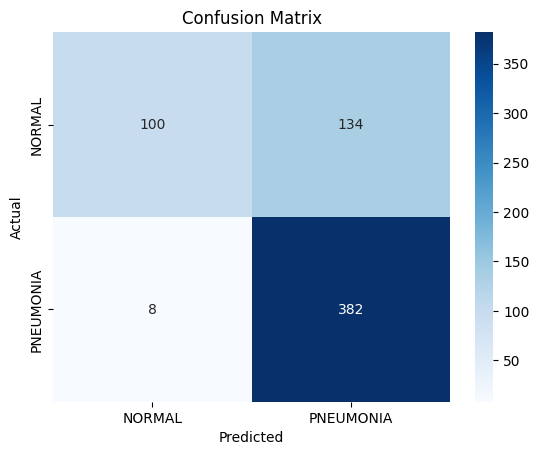

In [35]:
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Classification Report
- Generate precision, recall, F1-score, and support for both classes.
- Provides deeper insights into model performance beyond accuracy.

In [36]:
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

              precision    recall  f1-score   support

      NORMAL       0.93      0.43      0.58       234
   PNEUMONIA       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.83      0.70      0.71       624
weighted avg       0.81      0.77      0.75       624

